# Evaluating Referring Expression for COCO dataset

An example of Referring Expression for COCO with ViLBERT 12-in-1 as a visual and language comprehensor approach and FasteRCNN as a features extractor.

In [1]:
import sys
import os
import torch
import yaml

from easydict import EasyDict as edict
from pytorch_transformers.tokenization_bert import BertTokenizer
from vilbert.datasets import ConceptCapLoaderTrain, ConceptCapLoaderVal
from vilbert.vilbert import VILBertForVLTasks, BertConfig, BertForMultiModalPreTraining
from vilbert.task_utils import LoadDatasetEval

import numpy as np
import matplotlib.pyplot as plt
import PIL

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict
from PIL import Image
import cv2
import argparse
import glob
from types import SimpleNamespace
import pdb

%matplotlib inline  

## Feature Extractor: FasterCNN

Defintion of the FeatureExtractor Object

In [2]:
device_type = 'cuda'

In [3]:
class FeatureExtractor:
    MAX_SIZE = 1333
    MIN_SIZE = 800

    def __init__(self):
        self.args = self.get_parser()
        self.detection_model = self._build_detection_model()

    def get_parser(self):        
        parser = SimpleNamespace(model_file='models/detectron/detectron_model.pth', #'save/resnext_models/model_final.pth',
                                config_file='models/detectron/detectron_config.yaml', #'save/resnext_models/e2e_faster_rcnn_X-152-32x8d-FPN_1x_MLP_2048_FPN_512_train.yaml',
                                batch_size=1,
                                num_features=100,
                                feature_name="fc6",
                                confidence_threshold=0,
                                background=False,
                                partition=0)
        return parser
    
    def _build_detection_model(self):
        cfg.merge_from_file(self.args.config_file)
        cfg.freeze()

        model = build_detection_model(cfg)
        checkpoint = torch.load(self.args.model_file, map_location=torch.device('cpu'))

        load_state_dict(model, checkpoint.pop("model"))

        model.to(device_type)
        model.eval()
        return model

    def _image_transform(self, path):
        img = Image.open(path)
        im = np.array(img).astype(np.float32)
        # IndexError: too many indices for array, grayscale images
        if len(im.shape) < 3:
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
        im = im[:, :, ::-1]
        im -= np.array([102.9801, 115.9465, 122.7717])
        im_shape = im.shape
        im_height = im_shape[0]
        im_width = im_shape[1]
        im_size_min = np.min(im_shape[0:2])
        im_size_max = np.max(im_shape[0:2])

        # Scale based on minimum size
        im_scale = self.MIN_SIZE / im_size_min

        # Prevent the biggest axis from being more than max_size
        # If bigger, scale it down
        if np.round(im_scale * im_size_max) > self.MAX_SIZE:
            im_scale = self.MAX_SIZE / im_size_max

        im = cv2.resize(
            im, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR
        )
        img = torch.from_numpy(im).permute(2, 0, 1)

        im_info = {"width": im_width, "height": im_height}

        return img, im_scale, im_info

    def _process_feature_extraction(
        self, output, im_scales, im_infos, feature_name="fc6", conf_thresh=0
    ):
        batch_size = len(output[0]["proposals"])
        n_boxes_per_image = [len(boxes) for boxes in output[0]["proposals"]]
        score_list = output[0]["scores"].split(n_boxes_per_image)
        score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
        feats = output[0][feature_name].split(n_boxes_per_image)
        cur_device = score_list[0].device

        feat_list = []
        info_list = []

        for i in range(batch_size):
            dets = output[0]["proposals"][i].bbox / im_scales[i]
            scores = score_list[i]
            max_conf = torch.zeros((scores.shape[0])).to(cur_device)
            conf_thresh_tensor = torch.full_like(max_conf, conf_thresh)
            start_index = 1
            # Column 0 of the scores matrix is for the background class
            if self.args.background:
                start_index = 0
            for cls_ind in range(start_index, scores.shape[1]):
                cls_scores = scores[:, cls_ind]
                keep = nms(dets, cls_scores, 0.5)
                max_conf[keep] = torch.where(
                    # Better than max one till now and minimally greater than conf_thresh
                    (cls_scores[keep] > max_conf[keep])
                    & (cls_scores[keep] > conf_thresh_tensor[keep]),
                    cls_scores[keep],
                    max_conf[keep],
                )

            sorted_scores, sorted_indices = torch.sort(max_conf, descending=True)
            num_boxes = (sorted_scores[: self.args.num_features] != 0).sum()
            keep_boxes = sorted_indices[: self.args.num_features]
            feat_list.append(feats[i][keep_boxes])
            bbox = output[0]["proposals"][i][keep_boxes].bbox / im_scales[i]
            # Predict the class label using the scores
            objects = torch.argmax(scores[keep_boxes][start_index:], dim=1)
            cls_prob = torch.max(scores[keep_boxes][start_index:], dim=1)

            info_list.append(
                {
                    "bbox": bbox.cpu().numpy(),
                    "num_boxes": num_boxes.item(),
                    "objects": objects.cpu().numpy(),
                    "image_width": im_infos[i]["width"],
                    "image_height": im_infos[i]["height"],
                    "cls_prob": scores[keep_boxes].cpu().numpy(),
                }
            )

        return feat_list, info_list

    def get_detectron_features(self, image_paths):
        img_tensor, im_scales, im_infos = [], [], []

        for image_path in image_paths:
            im, im_scale, im_info = self._image_transform(image_path)
            img_tensor.append(im)
            im_scales.append(im_scale)
            im_infos.append(im_info)

        # Image dimensions should be divisible by 32, to allow convolutions
        # in detector to work
        current_img_list = to_image_list(img_tensor, size_divisible=32)
        current_img_list = current_img_list.to(device_type)

        with torch.no_grad():
            output = self.detection_model(current_img_list)

        feat_list = self._process_feature_extraction(
            output,
            im_scales,
            im_infos,
            self.args.feature_name,
            self.args.confidence_threshold,
        )

        return feat_list

    def _chunks(self, array, chunk_size):
        for i in range(0, len(array), chunk_size):
            yield array[i : i + chunk_size]

    def _save_feature(self, file_name, feature, info):
        file_base_name = os.path.basename(file_name)
        file_base_name = file_base_name.split(".")[0]
        info["image_id"] = file_base_name
        info["features"] = feature.cpu().numpy()
        file_base_name = file_base_name + ".npy"

        np.save(os.path.join(self.args.output_folder, file_base_name), info)

    def extract_features(self, image_path):

        features, infos = self.get_detectron_features([image_path])

        return features, infos


## Additional required functions

In [4]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

def printer(sent, should_detokenize=True):
    if should_detokenize:
        sent = detokenize(sent)[1:-1]
    print(" ".join(sent))

def show_boxes2(img_path, boxes, colors, texts=None, masks=None):
    # boxes [[xyxy]]
    plt.imshow(img)
    ax = plt.gca()
    print('boxes: ',boxes)
    for k in range(boxes.shape[0]):
        box = boxes[k]
        xmin, ymin, xmax, ymax = list(box)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[k]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        if texts is not None:
            ax.text(xmin, ymin, texts[k], bbox={'facecolor':'blue', 'alpha':0.5},fontsize=8, color='white')
# write arbitary string for given sentense. 
import _pickle as cPickle

def dataLoader(path):
    extraction_save = np.load(path, allow_pickle=True).reshape(-1,1)[0][0]
    feat = [torch.from_numpy(extraction_save['features']).to('cuda')]
    infos = extraction_save
    infos.pop('features')
    infos.pop('image_id')
    return feat, [infos]

## Predicting Referring Expression with ViLBERT

ViLBERT 12-in-1 has been trained in 12 different tasks for which each of them have singular output header but a common body. For the Refering Expression task we will be focous on the vision grounding. Therefore, we will only work with the vision_logit output of ViLBERT, which provides us with the matching score between the visual input (proposals) and the expression (query). The one with the highest score will be the selected region.

The function *_prediction_refering_expression_* will show the top 10 proposals for a given expression and will also return the selected based on its higher score.

In [5]:
def prediction_refering_expression(question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, model, infos ):

    vil_prediction, vil_prediction_gqa, vil_logit, vil_binary_prediction, vil_tri_prediction, vision_prediction, vision_logit, linguisic_prediction, linguisic_logit, attn_data_list = model(
        question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, output_all_attention_masks=True
    )
    
    width, height = int(infos[0]['image_width']), int(infos[0]['image_height'])

    # grounding: 
    logits_vision = torch.max(vision_logit, 1)[1].data
    grounding_val, grounding_idx = torch.sort(vision_logit.squeeze(2), 1, True)    
    
     # for whole batch
    top_idx = grounding_idx[:,0].tolist()
    predicted_bboxes = []
    for indx, value in enumerate(top_idx):
        y1 = spatials[indx, value,1]*height
        # y1 = top_box[:,1] * height
        y2 = spatials[indx, value,3]*height
        #y2 = top_box[:,3] * height
        x1 = spatials[indx, value,0]*width
        #x1 = top_box[:,0] * width
        x2 = spatials[indx, value,2]*width
        #x2 = top_box[:,2] * width
        predicted_bboxes.append([x1.item(), y1.item(), x2.item(), y2.item()])
        
        examples_per_row = min(10, len(grounding_idx[indx]))
        ncols = examples_per_row 
        nrows = 1
        figsize = [12, ncols*20]     # figure size, inches
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

        for i, axi in enumerate(ax.flat):
            idx = grounding_idx[indx, i]
            #print('idx: ', idx)
            val = grounding_val[indx, i]
            box = spatials[indx][idx][:4].tolist()
            y1 = int(box[1] * height)
            y2 = int(box[3] * height)
            x1 = int(box[0] * width)
            x2 = int(box[2] * width)

            #print('final area: ',spatials[indx][idx][4])
            # patch = img[y1:y2+y1,x1:x2+x1]
            patch = img[y1:y2,x1:x2]
            #print(patch)
            axi.imshow(patch)
            axi.axis('off')
            axi.set_title(str(i) + ": " + str(val.item()))
        plt.axis('off')
        plt.tight_layout(True)
        plt.show()    

    #print("shape: ", predicted_bboxes[0])
    show_boxes2(img,torch.from_numpy(np.array(predicted_bboxes[0])).unsqueeze_(0), ['blue'], texts=None)
    plt.show()
    
    
    return predicted_bboxes

## Data Preparation for ViLBERT

In [6]:
def custom_prediction(query, task, features, infos, tokenizer, model):

    num_image = len(infos)

    feature_list = []
    image_location_list = []
    image_mask_list = []
    text_list = []
    input_mask_list = []
    segment_ids_list = []
    task_list = []

    for i in range(num_image):
        tokens = tokenizer.encode(query[i])
        tokens = tokenizer.add_special_tokens_single_sentence(tokens)
        segment_ids = [0] * len(tokens)
        input_mask = [1] * len(tokens)

        max_length = 37
        if len(tokens) < max_length:
            # Note here we pad in front of the sentence
            padding = [0] * (max_length - len(tokens))
            tokens = tokens + padding
            input_mask += padding
            segment_ids += padding

        text_list.append(torch.from_numpy(np.array(tokens)).cuda().unsqueeze(0))
        input_mask_list.append(torch.from_numpy(np.array(input_mask)).cuda().unsqueeze(0))
        segment_ids_list.append(torch.from_numpy(np.array(segment_ids)).cuda().unsqueeze(0))
        task_list.append(torch.from_numpy(np.array(task)).cuda().unsqueeze(0))

        image_w = infos[i]['image_width']
        image_h = infos[i]['image_height']
        feature = features[i]
        num_boxes = feature.shape[0]

        g_feat = torch.sum(feature, dim=0) / num_boxes
        num_boxes = num_boxes + 1
        feature = torch.cat([g_feat.view(1,-1), feature], dim=0)
        boxes = infos[i]['bbox']
        image_location = np.zeros((boxes.shape[0], 5), dtype=np.float32)
        image_location[:,:4] = boxes
        image_location[:,4] = (image_location[:,3] - image_location[:,1]) * (image_location[:,2] - image_location[:,0]) / (float(image_w) * float(image_h))
        image_location[:,0] = image_location[:,0] / float(image_w)
        image_location[:,1] = image_location[:,1] / float(image_h)
        image_location[:,2] = image_location[:,2] / float(image_w)
        image_location[:,3] = image_location[:,3] / float(image_h)
        g_location = np.array([0,0,1,1,1])
        image_location = np.concatenate([np.expand_dims(g_location, axis=0), image_location], axis=0)
        image_mask = [1] * (int(num_boxes))

        feature_list.append(feature)
        image_location_list.append(torch.tensor(image_location))
        image_mask_list.append(torch.tensor(image_mask))

    features = torch.stack(feature_list, dim=0).float().cuda()
    spatials = torch.stack(image_location_list, dim=0).float().cuda()
    image_mask = torch.stack(image_mask_list, dim=0).byte().cuda()
    co_attention_mask = torch.zeros((num_image, num_boxes, max_length)).cuda()

    text = torch.stack(text_list, dim=0).long().cuda().squeeze(1)
    input_mask = torch.stack(input_mask_list, dim=0).long().cuda().squeeze(1)
    segment_ids = torch.stack(segment_ids_list, dim=0).long().cuda().squeeze(1)
    task = torch.stack(task_list, dim=0).long().cuda().squeeze(1)

    #print(features.shape, spatials.shape, image_mask.shape, co_attention_mask.shape, text.shape, input_mask.shape, segment_ids.shape, task.shape)
    #prediction(text, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task)
    _ = prediction_refering_expression(text, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task, model, infos)
    

## ViLBERT model

Afer running this cell we will load the ViLBERT model and the tokenizer, required for the data preparation.

In [7]:

# =============================
# ViLBERT part
# =============================


from pytorch_transformers.tokenization_bert import BertTokenizer

args = SimpleNamespace(from_pretrained= 'models/vilbert/multi_task_model.bin',#"save/refcoco_bert_base_6layer_6conect-finetune_from_multi_task_model_refcoco/pytorch_model_19.bin",
                       bert_model="bert-base-uncased",
                       config_file="config/bert_base_6layer_6conect.json",
                       max_seq_length=101,
                       train_batch_size=1,
                       do_lower_case=True,
                       predict_feature=False,
                       seed=42,
                       num_workers=0,
                       baseline=False,
                       img_weight=1,
                       distributed=False,
                       objective=1,
                       visual_target=0,
                       dynamic_attention=False,
                       task_specific_tokens=True,
                       tasks='1',
                       save_name='',
                       in_memory=False,
                       batch_size=1,
                       local_rank=-1,
                       split='mteval',
                       clean_train_sets=True
                      )

config = BertConfig.from_json_file(args.config_file)
with open('./vilbert_tasks.yml', 'r') as f:
    task_cfg = edict(yaml.safe_load(f))

task_names = []
for i, task_id in enumerate(args.tasks.split('-')):
    task = 'TASK' + task_id
    name = task_cfg[task]['name']
    task_names.append(name)

timeStamp = args.from_pretrained.split('/')[-1] + '-' + args.save_name
config = BertConfig.from_json_file(args.config_file)
default_gpu=True

if args.predict_feature:
    config.v_target_size = 2048
    config.predict_feature = True
else:
    config.v_target_size = 1601
    config.predict_feature = False

if args.task_specific_tokens:
    config.task_specific_tokens = True    

if args.dynamic_attention:
    config.dynamic_attention = True

config.visualization = True
num_labels = 3129

if args.baseline:
    model = BaseBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
else:
    model = VILBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
    
model.eval()
cuda = torch.cuda.is_available()
if cuda: model = model.cuda(0)
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)


11/13/2020 14:48:26 - INFO - vilbert.utils -   loading weights file models/vilbert/multi_task_model.bin
11/13/2020 14:48:59 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


## Feature Extractor

In [8]:
feature_extractor = FeatureExtractor()

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.bias                  loaded from backbone.body.layer1.0.bn1.bias                  of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.running_mean          loaded from backbone.body.layer1.0.bn1.running_mean          of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.running_var           loaded from backbone.body.layer1.0.bn1.running_var           of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.weight                loaded from backbone.body.layer1.0.bn1.weight                of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn2.bias                  loaded from backbone.body.layer1.0.bn2.bias              

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn2.running_mean          loaded from backbone.body.layer1.2.bn2.running_mean          of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn2.running_var           loaded from backbone.body.layer1.2.bn2.running_var           of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn2.weight                loaded from backbone.body.layer1.2.bn2.weight                of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn3.bias                  loaded from backbone.body.layer1.2.bn3.bias                  of shape (256,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn3.running_mean          loaded from backbone.body.layer1.2.bn3.running_mean      

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn3.running_var           loaded from backbone.body.layer2.1.bn3.running_var           of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn3.weight                loaded from backbone.body.layer2.1.bn3.weight                of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv1.weight              loaded from backbone.body.layer2.1.conv1.weight              of shape (512, 512, 1, 1)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv2.weight              loaded from backbone.body.layer2.1.conv2.weight              of shape (512, 16, 3, 3)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv3.weight              loaded from backbone.body.layer2.1.con

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn2.running_mean          loaded from backbone.body.layer2.4.bn2.running_mean          of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn2.running_var           loaded from backbone.body.layer2.4.bn2.running_var           of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn2.weight                loaded from backbone.body.layer2.4.bn2.weight                of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn3.bias                  loaded from backbone.body.layer2.4.bn3.bias                  of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn3.running_mean          loaded from backbone.body.layer2.4.bn3.running_mean      

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.bias                  loaded from backbone.body.layer2.7.bn1.bias                  of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.running_mean          loaded from backbone.body.layer2.7.bn1.running_mean          of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.running_var           loaded from backbone.body.layer2.7.bn1.running_var           of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.weight                loaded from backbone.body.layer2.7.bn1.weight                of shape (512,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn2.bias                  loaded from backbone.body.layer2.7.bn2.bias              

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn2.running_mean          loaded from backbone.body.layer3.1.bn2.running_mean          of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn2.running_var           loaded from backbone.body.layer3.1.bn2.running_var           of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn2.weight                loaded from backbone.body.layer3.1.bn2.weight                of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn3.bias                  loaded from backbone.body.layer3.1.bn3.bias                  of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn3.running_mean          loaded from backbone.body.layer3.1.bn3.running_mean  

11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.bias                 loaded from backbone.body.layer3.12.bn1.bias                 of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.running_mean         loaded from backbone.body.layer3.12.bn1.running_mean         of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.running_var          loaded from backbone.body.layer3.12.bn1.running_var          of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.weight               loaded from backbone.body.layer3.12.bn1.weight               of shape (1024,)
11/13/2020 14:49:28 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn2.bias                 loaded from backbone.body.layer3.12.bn2.bias         

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.bn3.running_var          loaded from backbone.body.layer3.14.bn3.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.bn3.weight               loaded from backbone.body.layer3.14.bn3.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv1.weight             loaded from backbone.body.layer3.14.conv1.weight             of shape (1024, 1024, 1, 1)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv2.weight             loaded from backbone.body.layer3.14.conv2.weight             of shape (1024, 32, 3, 3)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv3.weight             loaded from backbone.body.layer3.

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn2.running_mean         loaded from backbone.body.layer3.17.bn2.running_mean         of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn2.running_var          loaded from backbone.body.layer3.17.bn2.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn2.weight               loaded from backbone.body.layer3.17.bn2.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn3.bias                 loaded from backbone.body.layer3.17.bn3.bias                 of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn3.running_mean         loaded from backbone.body.layer3.17.bn3.running_mean 

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.bias                  loaded from backbone.body.layer3.2.bn1.bias                  of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.running_mean          loaded from backbone.body.layer3.2.bn1.running_mean          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.running_var           loaded from backbone.body.layer3.2.bn1.running_var           of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.weight                loaded from backbone.body.layer3.2.bn1.weight                of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn2.bias                  loaded from backbone.body.layer3.2.bn2.bias          

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.bn3.running_var          loaded from backbone.body.layer3.21.bn3.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.bn3.weight               loaded from backbone.body.layer3.21.bn3.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.conv1.weight             loaded from backbone.body.layer3.21.conv1.weight             of shape (1024, 1024, 1, 1)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.conv2.weight             loaded from backbone.body.layer3.21.conv2.weight             of shape (1024, 32, 3, 3)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.conv3.weight             loaded from backbone.body.layer3.

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn2.running_mean         loaded from backbone.body.layer3.24.bn2.running_mean         of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn2.running_var          loaded from backbone.body.layer3.24.bn2.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn2.weight               loaded from backbone.body.layer3.24.bn2.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn3.bias                 loaded from backbone.body.layer3.24.bn3.bias                 of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn3.running_mean         loaded from backbone.body.layer3.24.bn3.running_mean 

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.bias                 loaded from backbone.body.layer3.27.bn1.bias                 of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.running_mean         loaded from backbone.body.layer3.27.bn1.running_mean         of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.running_var          loaded from backbone.body.layer3.27.bn1.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.weight               loaded from backbone.body.layer3.27.bn1.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn2.bias                 loaded from backbone.body.layer3.27.bn2.bias         

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.bn3.running_var          loaded from backbone.body.layer3.29.bn3.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.bn3.weight               loaded from backbone.body.layer3.29.bn3.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.conv1.weight             loaded from backbone.body.layer3.29.conv1.weight             of shape (1024, 1024, 1, 1)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.conv2.weight             loaded from backbone.body.layer3.29.conv2.weight             of shape (1024, 32, 3, 3)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.conv3.weight             loaded from backbone.body.layer3.

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn2.running_mean         loaded from backbone.body.layer3.31.bn2.running_mean         of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn2.running_var          loaded from backbone.body.layer3.31.bn2.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn2.weight               loaded from backbone.body.layer3.31.bn2.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn3.bias                 loaded from backbone.body.layer3.31.bn3.bias                 of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn3.running_mean         loaded from backbone.body.layer3.31.bn3.running_mean 

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.bias                 loaded from backbone.body.layer3.34.bn1.bias                 of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.running_mean         loaded from backbone.body.layer3.34.bn1.running_mean         of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.running_var          loaded from backbone.body.layer3.34.bn1.running_var          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.weight               loaded from backbone.body.layer3.34.bn1.weight               of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn2.bias                 loaded from backbone.body.layer3.34.bn2.bias         

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.bn3.running_var           loaded from backbone.body.layer3.4.bn3.running_var           of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.bn3.weight                loaded from backbone.body.layer3.4.bn3.weight                of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.conv1.weight              loaded from backbone.body.layer3.4.conv1.weight              of shape (1024, 1024, 1, 1)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.conv2.weight              loaded from backbone.body.layer3.4.conv2.weight              of shape (1024, 32, 3, 3)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.conv3.weight              loaded from backbone.body.layer3.

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.bias                  loaded from backbone.body.layer3.7.bn2.bias                  of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.running_mean          loaded from backbone.body.layer3.7.bn2.running_mean          of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.running_var           loaded from backbone.body.layer3.7.bn2.running_var           of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.weight                loaded from backbone.body.layer3.7.bn2.weight                of shape (1024,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn3.bias                  loaded from backbone.body.layer3.7.bn3.bias          

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.9.conv3.weight              loaded from backbone.body.layer3.9.conv3.weight              of shape (1024, 1024, 1, 1)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.bias                  loaded from backbone.body.layer4.0.bn1.bias                  of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.running_mean          loaded from backbone.body.layer4.0.bn1.running_mean          of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.running_var           loaded from backbone.body.layer4.0.bn1.running_var           of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.weight                loaded from backbone.body.layer4.0.bn1.wei

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.bias                  loaded from backbone.body.layer4.2.bn2.bias                  of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.running_mean          loaded from backbone.body.layer4.2.bn2.running_mean          of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.running_var           loaded from backbone.body.layer4.2.bn2.running_var           of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.weight                loaded from backbone.body.layer4.2.bn2.weight                of shape (2048,)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn3.bias                  loaded from backbone.body.layer4.2.bn3.bias          

11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.0              loaded from rpn.anchor_generator.cell_anchors.0              of shape (3, 4)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.1              loaded from rpn.anchor_generator.cell_anchors.1              of shape (3, 4)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.2              loaded from rpn.anchor_generator.cell_anchors.2              of shape (3, 4)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.3              loaded from rpn.anchor_generator.cell_anchors.3              of shape (3, 4)
11/13/2020 14:49:29 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.4              loaded from rpn.anchor_generator.cell_anchors.4          

## Example Referring Expression

Here we will load 3 different features and infos (*_feat, feat_pre, feat_gt_*), all extracted from the same image *_demo/images/3.jpg_*. The first one are directly extracted with the FeatureExtractor() class decribed before, the second one are the precomputed by *_extract_features.py_* without giving any proposals and the third one are the one extracted with the proposals of the COCO dataset.

### Prepare features and infos for selected image

In [10]:
path_feat = './data/features/fastercnn_proposals/COCO_train2014_000000581563.npy'
path_feat_gt = './data/features/coco_gt/COCO_train2014_000000581563.npy'

feat_pre, infos_pre = dataLoader(path_feat)
feat_gt, infos_gt = dataLoader(path_feat_gt)

image_path = 'demo/images/3.jpg'
feat, infos = feature_extractor.extract_features(image_path)

### Ask me
Run the next cell to viasualzie the image, then, write an expression and see the answer of ViLBERT :)

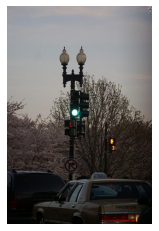

In [15]:
img = PIL.Image.open(image_path).convert('RGB')
img = torch.tensor(np.array(img))
plt.axis('off')
plt.imshow(img)
plt.show()

Enter query or q to quit: lamps


/home/mikel/miniconda3/envs/vilbert/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


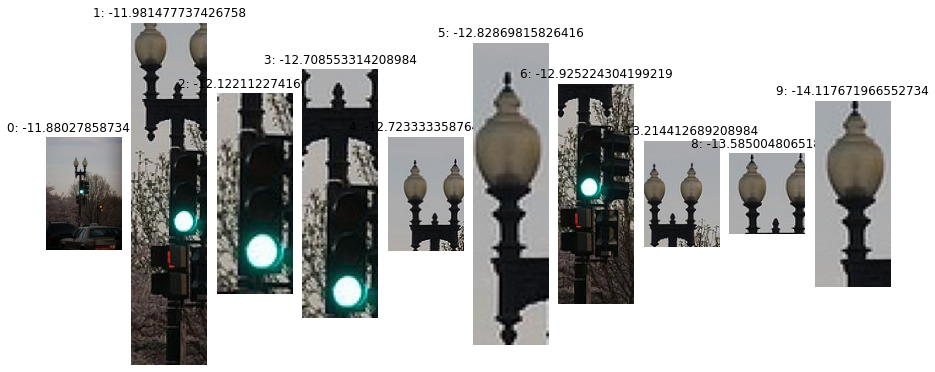

boxes:  tensor([[  0.,   0., 333., 500.]], dtype=torch.float64)


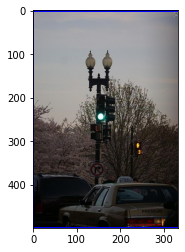

['lamps']
Enter query or q to quit: street lamps


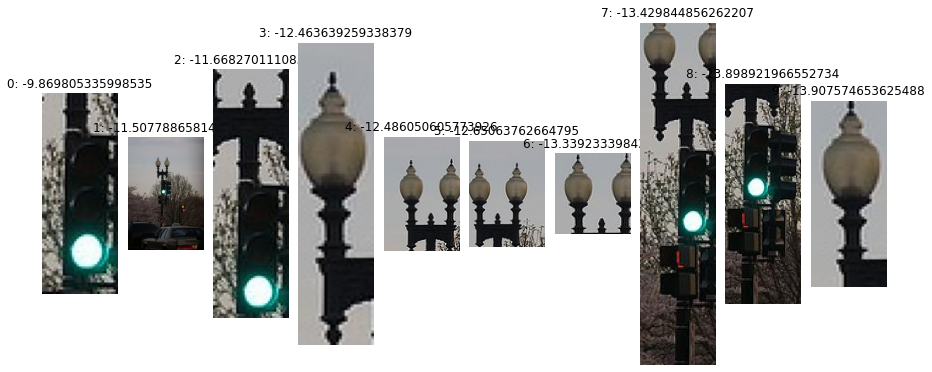

boxes:  tensor([[136.8983, 175.6269, 169.3261, 263.0742]], dtype=torch.float64)


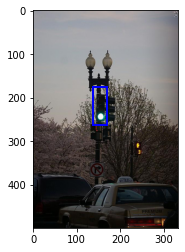

['street lamps']
Enter query or q to quit: street white lamps


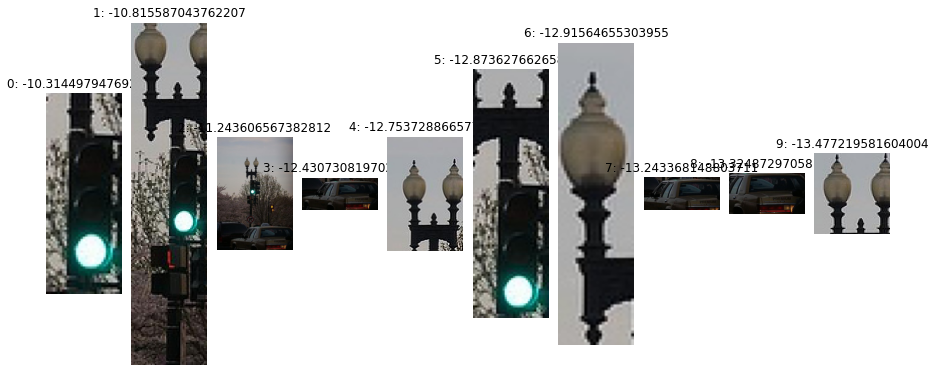

boxes:  tensor([[136.8983, 175.6269, 169.3261, 263.0742]], dtype=torch.float64)


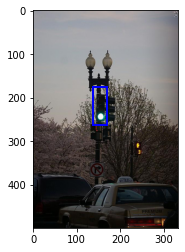

['street white lamps']
Enter query or q to quit: two street light


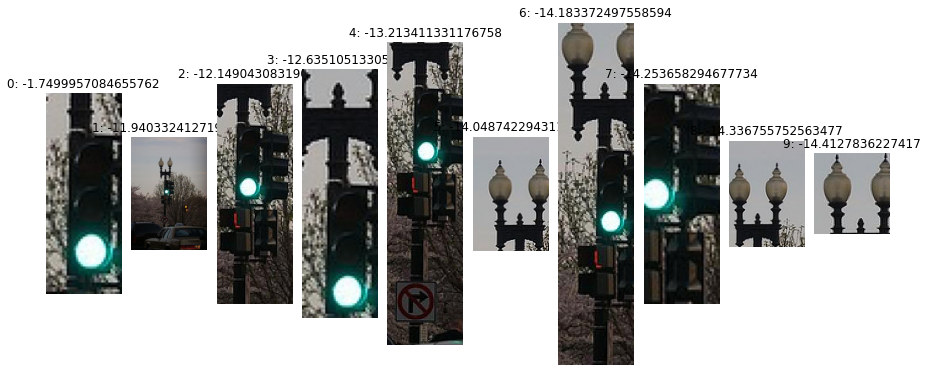

boxes:  tensor([[136.8983, 175.6269, 169.3261, 263.0742]], dtype=torch.float64)


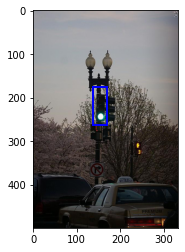

['two street light']
Enter query or q to quit: post with two lights on top


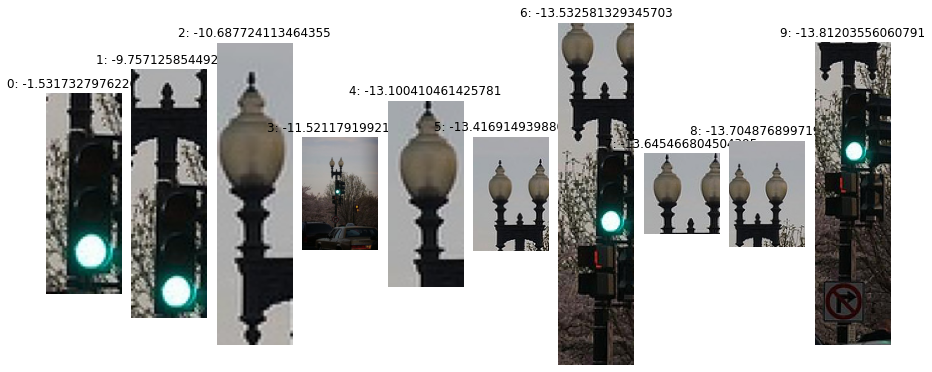

boxes:  tensor([[136.8983, 175.6269, 169.3261, 263.0742]], dtype=torch.float64)


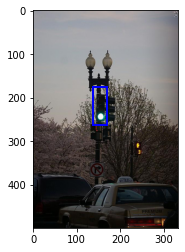

['post with two lights on top']


KeyboardInterrupt: Interrupted by user

In [17]:
while True:
    expr = input("Enter query or q to quit: ")
    if expr=='q':
        break
    query = [expr]
    task = [9]
    custom_prediction(query, task, feat, infos, tokenizer, model)
    print(query)